# Feature Engineering

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import xgbfir
import umap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from zipfile import ZipFile

from eli5 import show_weights
from os.path import join as pjoin
from sklearn.decomposition import PCA

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
np.random.seed(24)


Airbnb New User Bookings from https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings. Our task is to predict which country a new user's first booking destination will be.

In [2]:
train = pd.read_csv('./data/airbnb-recruiting/train_users_2.csv')
train.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [3]:
train = train.drop('date_first_booking', axis=1)


In [4]:
target_names = train['country_destination'].unique()
target_names


array(['NDF', 'US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL',
       'DE', 'AU'], dtype=object)

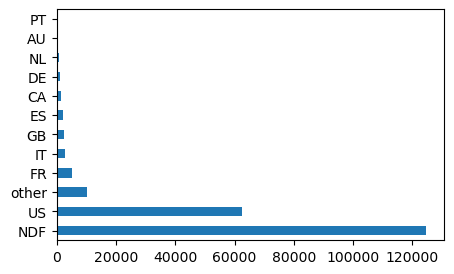

In [5]:
plt.figure(figsize=(5, 3))
train['country_destination'].value_counts().plot(kind='barh');


In [ ]:
train['country_destination'].value_counts(normalize=True)


NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [ ]:
def get_train_test(df):
    X = df.drop(columns=['country_destination', 'id'])
    y = df['country_destination']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    return X_train, X_test, y_train, y_test


In [ ]:
def get_feat_types(df):
    numeric_features = df.select_dtypes('number').columns
    categorical_features = df.select_dtypes('object').columns
    return numeric_features, categorical_features


In [ ]:
def get_train_transform(df):
    X_train, X_test, y_train, y_test = get_train_test(df)
    numeric_features, categorical_features = get_feat_types(X_train)


    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
        ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train_transform = preprocessor.fit_transform(X_train)

    y_transformer = LabelEncoder()
    y_train_enc = y_transformer.fit_transform(y_train)

    return X_train_transform, y_train_enc


In [ ]:
def get_train_test_transform(df):
    X_train, X_test, y_train, y_test = get_train_test(df)
    numeric_features, categorical_features = get_feat_types(X_train)


    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
        ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train_transform = preprocessor.fit_transform(X_train)
    X_test_transform = preprocessor.transform(X_test)

    y_transformer = LabelEncoder()
    y_train_enc = y_transformer.fit_transform(y_train)
    y_test_enc = y_transformer.transform(y_test)

    return X_train_transform, X_test_transform, y_train_enc, y_test_enc


In [ ]:
def make_predict(classifier, preprocessor, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    print(classifier)

    y_pred = pipeline.predict(X_test)
    print("accuracy: ", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    return


## Baseline

In [ ]:
X_train, X_test, y_train, y_test = get_train_test(train)
numeric_features, categorical_features = get_feat_types(X_train)


In [ ]:
#define transformers as pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    ])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder(dtype='float16', handle_unknown='use_encoded_value', unknown_value=-1))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [ ]:
make_predict(ExtraTreesClassifier(random_state=24),
             preprocessor, X_train, y_train, X_test, y_test)


ExtraTreesClassifier(random_state=24)
accuracy:  0.5492726804244454
              precision    recall  f1-score   support

         NDF       0.00      0.00      0.00       101
          US       0.01      0.00      0.00       312
       other       0.01      0.00      0.01       210
          FR       0.01      0.00      0.01       417
          CA       0.04      0.02      0.03      1041
          GB       0.03      0.01      0.02       476
          ES       0.03      0.01      0.02       576
          IT       0.66      0.75      0.70     24853
          PT       0.01      0.01      0.01       143
          NL       0.00      0.00      0.00        42
          DE       0.41      0.38      0.39     12535
          AU       0.06      0.03      0.04      1985

    accuracy                           0.55     42691
   macro avg       0.10      0.10      0.10     42691
weighted avg       0.51      0.55      0.53     42691



In [ ]:
X_train_transform, y_train_enc = get_train_transform(train)


In [ ]:
num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-merror:0.41116+0.00052	test-merror:0.41120+0.00084
[10]	train-merror:0.38664+0.00116	test-merror:0.38754+0.00193
[20]	train-merror:0.37310+0.00140	test-merror:0.37444+0.00106
[30]	train-merror:0.36959+0.00076	test-merror:0.37064+0.00170
[40]	train-merror:0.36797+0.00058	test-merror:0.36966+0.00154
[50]	train-merror:0.36658+0.00090	test-merror:0.36799+0.00140
[60]	train-merror:0.36607+0.00102	test-merror:0.36749+0.00106
[70]	train-merror:0.36559+0.00101	test-merror:0.36722+0.00132
[80]	train-merror:0.36520+0.00097	test-merror:0.36663+0.00145
[90]	train-merror:0.36471+0.00103	test-merror:0.36660+0.00127
[100]	train-merror:0.36434+0.00095	test-merror:0.36629+0.00133
[109]	train-merror:0.36392+0.00110	test-merror:0.36637+0.00151


## Feature Engineering

In [ ]:
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_account_created']


0        2010-06-28
1        2011-05-25
2        2010-09-28
3        2011-12-05
4        2010-09-14
            ...    
213446   2014-06-30
213447   2014-06-30
213448   2014-06-30
213449   2014-06-30
213450   2014-06-30
Name: date_account_created, Length: 213451, dtype: datetime64[ns]

In [ ]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format='%Y%m%d%H%M%S')
train['timestamp_first_active']


0        2009-03-19 04:32:55
1        2009-05-23 17:48:09
2        2009-06-09 23:12:47
3        2009-10-31 06:01:29
4        2009-12-08 06:11:05
                 ...        
213446   2014-06-30 23:56:36
213447   2014-06-30 23:57:19
213448   2014-06-30 23:57:54
213449   2014-06-30 23:58:22
213450   2014-06-30 23:58:24
Name: timestamp_first_active, Length: 213451, dtype: datetime64[ns]

In [ ]:
train['date_account_created_month'] = train['date_account_created'].dt.month
train['date_account_created_weekday'] = train['date_account_created'].dt.weekday
train['date_account_created_hour'] = train['date_account_created'].dt.hour

train['timestamp_first_active_month'] = train['timestamp_first_active'].dt.month
train['timestamp_first_active_weekday'] = train['timestamp_first_active'].dt.weekday
train['timestamp_first_active_hour'] = train['timestamp_first_active'].dt.hour


In [ ]:
train.isna().sum()


id                                    0
date_account_created                  0
timestamp_first_active                0
gender                                0
age                               87990
signup_method                         0
signup_flow                           0
language                              0
affiliate_channel                     0
affiliate_provider                    0
first_affiliate_tracked            6065
signup_app                            0
first_device_type                     0
first_browser                         0
country_destination                   0
date_account_created_month            0
date_account_created_weekday          0
date_account_created_hour             0
timestamp_first_active_month          0
timestamp_first_active_weekday        0
timestamp_first_active_hour           0
dtype: int64

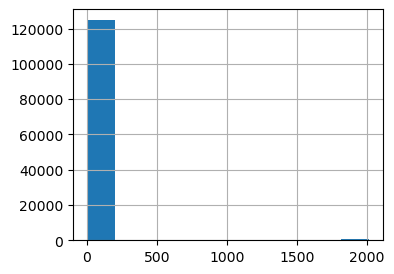

In [ ]:
plt.figure(figsize=(4, 3))
train['age'].hist();


In [ ]:
train['age'].describe()


count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

Age < 15 and > 100 replace with `np.nan`

In [ ]:
train.loc[((train['age'] < 15) | (train['age'] > 100)), 'age'] = np.nan


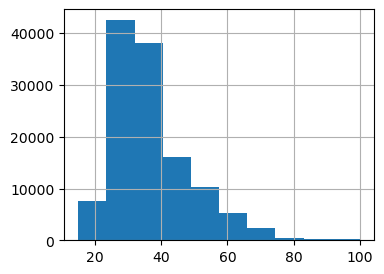

In [ ]:
plt.figure(figsize=(4, 3))
train['age'].hist();


In [ ]:
train['age'].isna().sum()


90392

In [ ]:
print(f"There are {train['age'].isna().sum()/train.shape[0]*100:.2f}% missing value in 'age' column")


There are 42.35% missing value in 'age' column


There are too many missing value in "age" to fill with simple global mean value. Let's try to group some columns to make sure there is enough variation while filling missing values in "age".


train["age_1"] = train["age"].fillna(
    train.groupby(['gender', 'signup_method', 'signup_app'])['age'].transform('mean')

train["age_2"] = train["age"].fillna(
    train.groupby(['gender', 'first_device_type'])['age'].transform('mean')
)

train["age_3"] = train["age"].fillna(
    train.groupby(['gender', 'affiliate_channel'])['age'].transform('mean')

In [ ]:
train["age"] = train["age"].fillna(
    train.groupby(['gender', 'signup_app'])['age'].transform('mean')
)
train["age"].isna().sum()


0

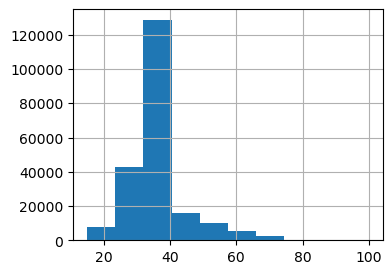

In [ ]:
plt.figure(figsize=(4, 3))
train['age'].hist();


### sessions

In [ ]:
with ZipFile('./data/airbnb-recruiting/sessions_csv.zip') as zip_file:
    sessions = pd.read_csv(zip_file.extract('sessions.csv'))


In [ ]:
sessions.sample(3)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
10354901,sv9jlsmnm8,request_new_confirm_email,click,request_new_confirm_email,Mac Desktop,660.0
9149352,7r4mggys4q,personalize,data,wishlist_content_update,Mac Desktop,796.0
10370414,ql9n9ly44m,campaigns,NaN,NaN,iPhone,83.0


In [10]:
# number of session for each user
session_count = sessions.user_id.value_counts().to_frame(name='session_count')
session_count['id'] = session_count.index
session_count


,session_count,id
mxqbh3ykxl,2722,mxqbh3ykxl
0hjoc5q8nf,2644,0hjoc5q8nf
mjbl6rrj52,2476,mjbl6rrj52
l5lgm3w5pc,2424,l5lgm3w5pc
wg9413iaux,2362,wg9413iaux
...,...,...
28ducycdim,1,28ducycdim
g09kkvjc6h,1,g09kkvjc6h
n02i24pakw,1,n02i24pakw
ac2u4y37a4,1,ac2u4y37a4


In [ ]:
train = train.merge(session_count, how='left', on='id')
train.head(3)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,first_device_type,first_browser,country_destination,date_account_created_month,date_account_created_weekday,date_account_created_hour,timestamp_first_active_month,timestamp_first_active_weekday,timestamp_first_active_hour,session_count
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,Mac Desktop,Chrome,NDF,6,0,0,3,3,4,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,Mac Desktop,Chrome,NDF,5,2,0,5,5,17,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,Windows Desktop,IE,US,9,1,0,6,1,23,NaN


In [ ]:
session_total = (sessions.loc[ : , ['user_id', 'secs_elapsed','action']]
    .groupby('user_id')
    .agg(total_actions=('action', 'count'),
         total_secs_elapsed=('secs_elapsed', 'sum'),
         mean_secs_elapsed=('secs_elapsed', 'mean'))
    .fillna(0))
session_total.reset_index(inplace=True)
session_total.rename(columns={'user_id': 'id'}, inplace=True)
session_total.head(3)


,id,total_actions,total_secs_elapsed,mean_secs_elapsed
0,00023iyk9l,39,867896.0,22253.743590
1,0010k6l0om,63,586543.0,9460.370968
2,001wyh0pz8,90,282965.0,3179.382022


In [ ]:
train = train.merge(session_total, how='left', on='id')
train.head(5)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,date_account_created_month,date_account_created_weekday,date_account_created_hour,timestamp_first_active_month,timestamp_first_active_weekday,timestamp_first_active_hour,session_count,total_actions,total_secs_elapsed,mean_secs_elapsed
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,6,0,0,3,3,4,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,5,2,0,5,5,17,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,9,1,0,6,1,23,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.000000,facebook,0,en,direct,direct,...,12,0,0,10,5,6,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.000000,basic,0,en,direct,direct,...,9,1,0,12,1,6,NaN,NaN,NaN,NaN


In [ ]:
action_type = (sessions.groupby(['user_id', 'action_type'])['secs_elapsed']
               .agg(['count', 'sum', 'mean'])
               .reset_index())
action_type.head()


,user_id,action_type,count,sum,mean
0,00023iyk9l,booking_request,1,0.0,0.000000
1,00023iyk9l,click,4,590691.0,147672.750000
2,00023iyk9l,data,9,7043.0,782.555556
3,00023iyk9l,message_post,1,129817.0,129817.000000
4,00023iyk9l,partner_callback,0,0.0,NaN


In [ ]:
action_type = (action_type
    .pivot(index='user_id', columns='action_type', values=['count', 'sum', 'mean'])
    .rename(columns={'-unknown-': 'unknown'})
    .reset_index()
    .fillna(0)
)

action_type.head()


user_id   count                                          \
action_type             unknown booking_request booking_response  click   
0            00023iyk9l     0.0             1.0              0.0    4.0   
1            0010k6l0om     5.0             0.0              0.0   16.0   
2            001wyh0pz8     6.0             0.0              0.0   66.0   
3            0028jgx1x1     1.0             0.0              0.0    9.0   
4            002qnbzfs5   184.0             1.0              0.0  140.0   

                                                                ...  \
action_type   data message_post modify partner_callback submit  ...   
0              9.0          1.0    0.0              0.0    0.0  ...   
1              9.0          0.0    0.0              0.0    0.0  ...   
2              2.0          0.0    0.0              0.0    2.0  ...   
3              5.0          0.0    0.0              0.0    0.0  ...   
4            140.0         16.0    0.0              0.0   15.0  ...   

                     mean                                                  \
action_type       unknown booking_request booking_response          click   
0                0.000000             0.0              0.0  147672.750000   
1            24606.600000             0.0              0.0    4122.125000   
2             3696.833333             0.0              0.0    2406.000000   
3              489.000000             0.0              0.0   22200.222222   
4             4011.788043         70986.0              0.0    4602.307143   

                                                                          \
action_type          data message_post modify partner_callback    submit   
0              782.555556  129817.0000    0.0              0.0       0.0   
1            15138.444444       0.0000    0.0              0.0       0.0   
2              775.000000       0.0000    0.0              0.0   25453.0   
3             1720.600000       0.0000    0.0              0.0       0.0   
4             2098.107143   20327.1875    0.0              0.0  102514.6   

                           
action_type          view  
0             6636.571429  
1            15305.647059  
2             5564.500000  
3             5874.400000  
4             1318.217593  

[5 rows x 31 columns]

In [ ]:
action_type.columns = ['action_type_'+'_'.join(col).strip() for col in action_type.columns.values]
action_type.rename(columns={'action_type_user_id_': 'id'}, inplace=True)
action_type.head(3)


,id,action_type_count_unknown,action_type_count_booking_request,action_type_count_booking_response,action_type_count_click,action_type_count_data,action_type_count_message_post,action_type_count_modify,action_type_count_partner_callback,action_type_count_submit,...,action_type_mean_unknown,action_type_mean_booking_request,action_type_mean_booking_response,action_type_mean_click,action_type_mean_data,action_type_mean_message_post,action_type_mean_modify,action_type_mean_partner_callback,action_type_mean_submit,action_type_mean_view
0,00023iyk9l,0.0,1.0,0.0,4.0,9.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,147672.750,782.555556,129817.0,0.0,0.0,0.0,6636.571429
1,0010k6l0om,5.0,0.0,0.0,16.0,9.0,0.0,0.0,0.0,0.0,...,24606.600000,0.0,0.0,4122.125,15138.444444,0.0,0.0,0.0,0.0,15305.647059
2,001wyh0pz8,6.0,0.0,0.0,66.0,2.0,0.0,0.0,0.0,2.0,...,3696.833333,0.0,0.0,2406.000,775.000000,0.0,0.0,0.0,25453.0,5564.500000


In [ ]:
train = train.merge(action_type, how='left', on='id')
train.head(5)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,action_type_mean_unknown,action_type_mean_booking_request,action_type_mean_booking_response,action_type_mean_click,action_type_mean_data,action_type_mean_message_post,action_type_mean_modify,action_type_mean_partner_callback,action_type_mean_submit,action_type_mean_view
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.000000,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.000000,basic,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sessions['device_type'].value_counts(dropna=False)


Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [ ]:
device_type = (sessions.groupby(['user_id', 'device_type'])['secs_elapsed']
               .agg(['count', 'mean', 'sum'])
               .reset_index())

device_type = (device_type
    .pivot(index='user_id', columns='device_type', values=['count', 'sum', 'mean'])
    .rename(columns={'-unknown-': 'unknown'})
    .reset_index()
    .fillna(0)
)

device_type.columns = ['device_type_'+'_'.join(col).strip().replace(' ', '_') for col in device_type.columns.values]
device_type.rename(columns={'device_type_user_id_': 'id'}, inplace=True)
device_type.head(3)


,id,device_type_count_unknown,device_type_count_Android_App_Unknown_Phone/Tablet,device_type_count_Android_Phone,device_type_count_Blackberry,device_type_count_Chromebook,device_type_count_Linux_Desktop,device_type_count_Mac_Desktop,device_type_count_Opera_Phone,device_type_count_Tablet,...,device_type_mean_Chromebook,device_type_mean_Linux_Desktop,device_type_mean_Mac_Desktop,device_type_mean_Opera_Phone,device_type_mean_Tablet,device_type_mean_Windows_Desktop,device_type_mean_Windows_Phone,device_type_mean_iPad_Tablet,device_type_mean_iPhone,device_type_mean_iPodtouch
0,00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,...,0.0,0.0,8446.914286,0.0,0.0,0.0,0.0,0.0,143063.5,0.0
1,0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,0.0,...,0.0,0.0,9460.370968,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001wyh0pz8,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train = train.merge(device_type, how='left', on='id')
train.head(5)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,device_type_mean_Chromebook,device_type_mean_Linux_Desktop,device_type_mean_Mac_Desktop,device_type_mean_Opera_Phone,device_type_mean_Tablet,device_type_mean_Windows_Desktop,device_type_mean_Windows_Phone,device_type_mean_iPad_Tablet,device_type_mean_iPhone,device_type_mean_iPodtouch
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.303064,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.000000,facebook,0,en,seo,google,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.000000,basic,3,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.000000,facebook,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.000000,basic,0,en,direct,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train model

In [ ]:
X_train_transform, y_train_enc = get_train_transform(train)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-merror:0.39073+0.00116	test-merror:0.39086+0.00103
[10]	train-merror:0.37365+0.00078	test-merror:0.37420+0.00053
[20]	train-merror:0.36470+0.00073	test-merror:0.36601+0.00119
[30]	train-merror:0.35943+0.00059	test-merror:0.36008+0.00129
[40]	train-merror:0.35717+0.00055	test-merror:0.35846+0.00110
[50]	train-merror:0.35558+0.00073	test-merror:0.35717+0.00103
[60]	train-merror:0.35442+0.00064	test-merror:0.35635+0.00144
[70]	train-merror:0.35325+0.00031	test-merror:0.35564+0.00137
[80]	train-merror:0.35225+0.00029	test-merror:0.35485+0.00107
[90]	train-merror:0.35126+0.00057	test-merror:0.35446+0.00128
[100]	train-merror:0.35054+0.00056	test-merror:0.35415+0.00133
[110]	train-merror:0.34978+0.00049	test-merror:0.35377+0.00151
[120]	train-merror:0.34921+0.00052	test-merror:0.35365+0.00145
[130]	train-merror:0.34868+0.00055	test-merror:0.35334+0.00157
[140]	train-merror:0.34822+0.00041	test-merror:0.35310+0.00157
[150]	train-merror:0.34765+0.00030	test-merror:0.35307+0.00156
[16

previuos result:	

train-merror:0.36392+0.00110	test-merror:0.36637+0.00151

##  Feature Interactions

In [ ]:
model = xgb.train(parameters, xgb_train, num_boost_round=220)


In [ ]:
black_list = ['id', 'country_destination']
feature_names = train.select_dtypes(['number', 'object']).columns.to_list()
feature_names = [feat for feat in feature_names if feat not in black_list]


In [ ]:
xgbfir.saveXgbFI(
    model,
    feature_names=feature_names,
    OutputXlsxFile=pjoin("./data/airbnb-recruiting", "xgbfir_importance.xlsx")
)


In [ ]:
train_fir = train.copy()


device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop
device_type_mean_Mac_Desktop|gender
device_type_mean_Linux_Desktop|gender
gender|gender
date_account_created_hour|device_type_mean_Mac_Desktop
date_account_created_hour|device_type_mean_Linux_Desktop
date_account_created_hour|first_browser

date_account_created_hour|device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop
device_type_mean_Linux_Desktop|gender|gender
date_account_created_hour|device_type_mean_iPodtouch|first_browser
action_type_sum_booking_response|device_type_mean_Mac_Desktop|gender
device_type_mean_Mac_Desktop|gender|gender
device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop|gender
action_type_sum_booking_response|device_type_mean_Linux_Desktop|gender

In [ ]:
# device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop
train_fir['device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop'] = (
            train_fir['device_type_mean_Linux_Desktop']
            - train_fir['device_type_mean_Mac_Desktop'])

# device_type_mean_Mac_Desktop|gender
train_fir['device_type_mean_Mac_Desktop|gender'] = (
            train_fir['device_type_mean_Mac_Desktop'].astype(str)
            + '_'
            + train_fir['gender'])

# device_type_mean_Linux_Desktop|gender
train_fir['device_type_mean_Linux_Desktop|gender'] = (
            train_fir['device_type_mean_Linux_Desktop'].astype(str)
            + '_'
            + train_fir['gender'])

# date_account_created_hour|device_type_mean_Mac_Desktop
train_fir['date_account_created_hour|device_type_mean_Mac_Desktop'] = (
            train_fir['date_account_created_hour'].astype(str)
            + '_'
            + train_fir['device_type_mean_Mac_Desktop'].astype(str))

# date_account_created_hour|device_type_mean_Linux_Desktop
train_fir['date_account_created_hour|device_type_mean_Linux_Desktop'] = (
            train_fir['date_account_created_hour'].astype(str)
            + '_'
            + train_fir['device_type_mean_Linux_Desktop'].astype(str))

# date_account_created_hour|first_browser
train_fir['date_account_created_hour|first_browser'] = (
            train_fir['date_account_created_hour'].astype(str)
            + '_'
            + train_fir['first_browser'])

# date_account_created_hour|device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop
train_fir['date_account_created_hour|device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop'] = (
            train_fir['date_account_created_hour'].astype(str)
            + '_'
            + train_fir['device_type_mean_Linux_Desktop'].astype(str)
            + '_'
            + train_fir['device_type_mean_Mac_Desktop'].astype(str))

# date_account_created_hour|device_type_mean_iPodtouch|first_browser
train_fir['date_account_created_hour|device_type_mean_iPodtouch|first_browser'] = (
            train_fir['date_account_created_hour'].astype(str)
            + '_'
            + train_fir['device_type_mean_iPodtouch'].astype(str)
            + '_'
            + train_fir['first_browser'])

# action_type_sum_booking_response|device_type_mean_Mac_Desktop|gender
train_fir['action_type_sum_booking_response|device_type_mean_Mac_Desktop|gender'] = (
            train_fir['action_type_sum_booking_response'].astype(str)
            + '_'
            + train_fir['device_type_mean_Mac_Desktop'].astype(str)
            + '_'
            + train_fir['gender'])

# device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop|gender
train_fir['device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop|gender'] = (
            train_fir['device_type_mean_Linux_Desktop'].astype(str)
            + '_'
            + train_fir['device_type_mean_Mac_Desktop'].astype(str)
            + '_'
            + train_fir['gender'])

# action_type_sum_booking_response|device_type_mean_Linux_Desktop|gender
train_fir['action_type_sum_booking_response|device_type_mean_Linux_Desktop|gender'] = (
            train_fir['action_type_sum_booking_response'].astype(str)
            + '_'
            + train_fir['device_type_mean_Linux_Desktop'].astype(str)
            + '_'
            + train_fir['gender'])


In [ ]:
train_fir.shape


(213451, 108)

In [ ]:
X_train_transform, y_train_enc = get_train_transform(train_fir)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-merror:0.36774+0.00135	test-merror:0.36774+0.00268
[10]	train-merror:0.36620+0.00067	test-merror:0.36639+0.00113
[20]	train-merror:0.36071+0.00024	test-merror:0.36209+0.00125
[30]	train-merror:0.35833+0.00039	test-merror:0.35976+0.00133
[40]	train-merror:0.35645+0.00022	test-merror:0.35829+0.00122
[50]	train-merror:0.35504+0.00044	test-merror:0.35707+0.00114
[60]	train-merror:0.35368+0.00085	test-merror:0.35584+0.00116
[70]	train-merror:0.35262+0.00064	test-merror:0.35508+0.00133
[80]	train-merror:0.35189+0.00052	test-merror:0.35473+0.00118
[90]	train-merror:0.35101+0.00069	test-merror:0.35442+0.00139
[100]	train-merror:0.35016+0.00067	test-merror:0.35412+0.00153
[110]	train-merror:0.34960+0.00053	test-merror:0.35361+0.00149
[120]	train-merror:0.34895+0.00062	test-merror:0.35321+0.00137
[130]	train-merror:0.34852+0.00077	test-merror:0.35307+0.00128
[140]	train-merror:0.34786+0.00077	test-merror:0.35287+0.00129
[150]	train-merror:0.34733+0.00079	test-merror:0.35266+0.00134
[16

previuos result:

train-merror:0.34466+0.00030	test-merror:0.35251+0.00146

## Target Encoding for gender

In [ ]:
train_te = train_fir.copy()


In [ ]:
y = train_te['country_destination']
y


0           NDF
1           NDF
2            US
3         other
4            US
          ...  
213446      NDF
213447      NDF
213448      NDF
213449      NDF
213450      NDF
Name: country_destination, Length: 213451, dtype: object

In [ ]:
y_enc = LabelEncoder().fit_transform(y)
y_enc


array([ 7,  7, 10, ...,  7,  7,  7])

In [ ]:
train_te.drop(
    columns=['date_account_created', 'timestamp_first_active'],
    axis=1, inplace=True)
train_te.head(3)


,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,device_type_mean_Mac_Desktop|gender,device_type_mean_Linux_Desktop|gender,date_account_created_hour|device_type_mean_Mac_Desktop,date_account_created_hour|device_type_mean_Linux_Desktop,date_account_created_hour|first_browser,date_account_created_hour|device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop,date_account_created_hour|device_type_mean_iPodtouch|first_browser,action_type_sum_booking_response|device_type_mean_Mac_Desktop|gender,device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop|gender,action_type_sum_booking_response|device_type_mean_Linux_Desktop|gender
0,gxn3p5htnn,-unknown-,37.303064,facebook,0,en,direct,direct,untracked,Web,...,nan_-unknown-,nan_-unknown-,0_nan,0_nan,0_Chrome,0_nan_nan,0_nan_Chrome,nan_nan_-unknown-,nan_nan_-unknown-,nan_nan_-unknown-
1,820tgsjxq7,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,...,nan_MALE,nan_MALE,0_nan,0_nan,0_Chrome,0_nan_nan,0_nan_Chrome,nan_nan_MALE,nan_nan_MALE,nan_nan_MALE
2,4ft3gnwmtx,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,...,nan_FEMALE,nan_FEMALE,0_nan,0_nan,0_IE,0_nan_nan,0_nan_IE,nan_nan_FEMALE,nan_nan_FEMALE,nan_nan_FEMALE


In [ ]:
train_te['first_affiliate_tracked'].fillna('unknown', inplace=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_te,
    y_enc,
    test_size=0.2,
    random_state=24,
    stratify=y
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(170760, 106) (170760,) (42691, 106) (42691,)


In [ ]:
class TargetFeatureEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y

        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) /
                (temp['y']['size'] + self.C)
            ).to_dict()

        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data


In [ ]:
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = TargetFeatureEncoding()
    new_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split],
            new_train_y[new_train_split],
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val


In [ ]:
features = ['gender', 'signup_method', 'signup_app', 'first_device_type']


In [ ]:
%%time

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(X_train, y_train):
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        X_train.iloc[train_split],
        y_train[train_split],
        X_train.iloc[val_split],
        features
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = TargetFeatureEncoding()
    se.fit(X_train.iloc[train_split], y_train[train_split], features)
    main_train_dfs.append(
        se.transform(X_train.iloc[val_split], inplace=False)
    )

se.fit(X_train, y_train, features=features)
main_test = se.transform(X_test, inplace=False)


CPU times: total: 20.8 s
Wall time: 22.2 s


In [ ]:
train_te_new = pd.concat([i for i in main_train_dfs], axis=0, ignore_index=True)


In [ ]:
train_te_new = pd.concat([train_te_new, main_test], ignore_index=True)


In [ ]:
train_te_new.head(3)


,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,device_type_mean_Mac_Desktop|gender,device_type_mean_Linux_Desktop|gender,date_account_created_hour|device_type_mean_Mac_Desktop,date_account_created_hour|device_type_mean_Linux_Desktop,date_account_created_hour|first_browser,date_account_created_hour|device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop,date_account_created_hour|device_type_mean_iPodtouch|first_browser,action_type_sum_booking_response|device_type_mean_Mac_Desktop|gender,device_type_mean_Linux_Desktop|device_type_mean_Mac_Desktop|gender,action_type_sum_booking_response|device_type_mean_Linux_Desktop|gender
0,12s59vmpe6,8.05090,24.000000,7.809707,0,en,direct,direct,omg,7.869794,...,9232.944444444445_MALE,0.0_MALE,0_9232.944444444445,0_0.0,0_Safari,0_0.0_9232.944444444445,0_0.0_Safari,0.0_9232.944444444445_MALE,0.0_9232.944444444445_MALE,0.0_0.0_MALE
1,475heu4d6t,7.61431,47.000000,7.854900,0,en,direct,direct,omg,7.869794,...,nan_-unknown-,nan_-unknown-,0_nan,0_nan,0_Firefox,0_nan_nan,0_nan_Firefox,nan_nan_-unknown-,nan_nan_-unknown-,nan_nan_-unknown-
2,bfq1xv9k96,7.61431,37.303064,7.854900,0,en,sem-non-brand,google,omg,7.869794,...,19453.217391304348_-unknown-,0.0_-unknown-,0_19453.217391304348,0_0.0,0_Firefox,0_0.0_19453.217391304348,0_0.0_Firefox,0.0_19453.217391304348_-unknown-,0.0_19453.217391304348_-unknown-,0.0_0.0_-unknown-


In [ ]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-merror:0.39618+0.00163	test-merror:0.39627+0.00219
[10]	train-merror:0.37113+0.00143	test-merror:0.37209+0.00141
[20]	train-merror:0.36341+0.00087	test-merror:0.36444+0.00057
[30]	train-merror:0.36112+0.00107	test-merror:0.36213+0.00064
[40]	train-merror:0.35834+0.00080	test-merror:0.35959+0.00118
[50]	train-merror:0.35621+0.00086	test-merror:0.35798+0.00173
[60]	train-merror:0.35486+0.00120	test-merror:0.35687+0.00200
[70]	train-merror:0.35383+0.00150	test-merror:0.35621+0.00193
[80]	train-merror:0.35267+0.00144	test-merror:0.35539+0.00225
[90]	train-merror:0.35208+0.00132	test-merror:0.35505+0.00246
[100]	train-merror:0.35111+0.00128	test-merror:0.35463+0.00252
[110]	train-merror:0.35038+0.00133	test-merror:0.35426+0.00256
[120]	train-merror:0.34989+0.00134	test-merror:0.35394+0.00259
[130]	train-merror:0.34927+0.00149	test-merror:0.35365+0.00258
[140]	train-merror:0.34867+0.00152	test-merror:0.35353+0.00267
[147]	train-merror:0.34823+0.00149	test-merror:0.35347+0.00249


previous result: 

train-merror:0.34453+0.00068	test-merror:0.35220+0.00136

##  Dimensinality reduction

Let's try to use not important features (with weight=0) by replacing they with one or two features using dimensinality reduction.

In [ ]:
model = xgb.train(parameters, xgb_train, num_boost_round=220)


In [ ]:
show_weights(model,
             feature_names=train_te_new.drop(columns=['country_destination', 'id']).columns.values,
             top=200)


Weight,Feature
0.0711,action_type_count_unknown
0.0681,action_type_count_modify
0.0602,gender
0.0589,signup_method
0.0429,device_type_mean_Linux_Desktop|gender
0.0428,age
0.0381,session_count
0.0324,signup_flow
0.0214,device_type_mean_iPodtouch
0.0205,action_type_sum_unknown


In [ ]:
feat_to_drop = [
'action_type_count_partner_callback',
'device_type_mean_Linux_Desktop',
'device_type_sum_Android_Phone',
'device_type_sum_unknown',
'device_type_count_Tablet',
'device_type_count_Linux_Desktop',
'device_type_count_Android_Phone',
'signup_app',
'device_type_mean_Android_Phone',
'action_type_mean_submit',
'action_type_mean_booking_request',
'action_type_sum_partner_callback',
'device_type_mean_unknown',
'action_type_sum_booking_request',
'action_type_count_booking_request',]


In [ ]:
pca = PCA(n_components=2, random_state=24)
X_reduced = pca.fit_transform(train_te_new[feat_to_drop])
X_reduced


array([[-15008.54158803, -13172.23171373],
       [-14999.53619262, -13163.84256414],
       [-15008.54158794, -13172.23171313],
       ...,
       [-14999.53623633, -13163.84260486],
       [-14999.53623633, -13163.84260486],
       [-14989.68032129, -13127.1812822 ]])

In [ ]:
train_pca = train_te_new.drop(feat_to_drop, axis=1)
train_pca['pca_1'] = X_reduced[:, 0]
train_pca['pca_2'] = X_reduced[:, 1]


In [ ]:
X_train_transform, y_train_enc = get_train_transform(train_pca)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-merror:0.39177+0.00053	test-merror:0.39216+0.00063
[10]	train-merror:0.37170+0.00068	test-merror:0.37252+0.00082
[20]	train-merror:0.36609+0.00088	test-merror:0.36766+0.00048
[30]	train-merror:0.36331+0.00060	test-merror:0.36493+0.00048
[40]	train-merror:0.36061+0.00080	test-merror:0.36268+0.00049
[50]	train-merror:0.35851+0.00084	test-merror:0.36083+0.00103
[60]	train-merror:0.35729+0.00106	test-merror:0.35969+0.00150
[70]	train-merror:0.35590+0.00118	test-merror:0.35857+0.00153
[80]	train-merror:0.35516+0.00144	test-merror:0.35784+0.00144
[90]	train-merror:0.35399+0.00138	test-merror:0.35701+0.00158
[100]	train-merror:0.35340+0.00131	test-merror:0.35666+0.00191
[110]	train-merror:0.35287+0.00135	test-merror:0.35638+0.00195
[120]	train-merror:0.35223+0.00143	test-merror:0.35617+0.00183
[130]	train-merror:0.35175+0.00144	test-merror:0.35587+0.00187
[140]	train-merror:0.35115+0.00154	test-merror:0.35589+0.00184
[150]	train-merror:0.35057+0.00153	test-merror:0.35575+0.00201
[15

previous result: 

train-merror:0.34453+0.00068	test-merror:0.35220+0.00136

The result worsened.

Let try to use PCA with 20 components instead of all features.

In [ ]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)

pca = PCA(n_components=20, random_state=24)
X_reduced = pca.fit_transform(X_train_transform)

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_reduced, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


[0]	train-merror:0.41584+0.00138	test-merror:0.41577+0.00150
[10]	train-merror:0.41075+0.00037	test-merror:0.41142+0.00025
[20]	train-merror:0.40902+0.00028	test-merror:0.40993+0.00044
[30]	train-merror:0.40794+0.00051	test-merror:0.40914+0.00045
[40]	train-merror:0.40711+0.00030	test-merror:0.40863+0.00055
[50]	train-merror:0.40629+0.00022	test-merror:0.40806+0.00056
[60]	train-merror:0.40547+0.00040	test-merror:0.40779+0.00071
[70]	train-merror:0.40503+0.00032	test-merror:0.40764+0.00062
[80]	train-merror:0.40443+0.00030	test-merror:0.40753+0.00066
[90]	train-merror:0.40404+0.00036	test-merror:0.40737+0.00068
[100]	train-merror:0.40355+0.00028	test-merror:0.40722+0.00068
[110]	train-merror:0.40309+0.00030	test-merror:0.40713+0.00083
[120]	train-merror:0.40266+0.00036	test-merror:0.40699+0.00078
[130]	train-merror:0.40228+0.00036	test-merror:0.40706+0.00069
[140]	train-merror:0.40174+0.00036	test-merror:0.40693+0.00070
[150]	train-merror:0.40124+0.00031	test-merror:0.40690+0.00065
[16

The worst result, which was expected.

In [ ]:
idx_col_to_drop = [train_te_new.columns.get_loc(col) for col in feat_to_drop]
idx_col_to_drop


[30, 86, 69, 67, 61, 58, 55, 9, 83, 51, 44, 40, 81, 34, 24]

c:\Users\Scar\anaconda3\envs\projector\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


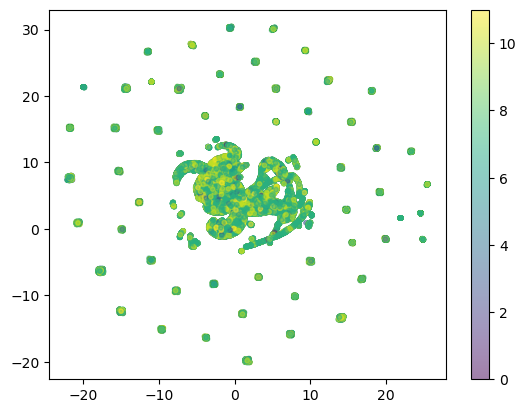

In [ ]:
X_embedding_umap = (umap.UMAP(n_neighbors=30, n_jobs=1, random_state=24)
                    .fit_transform(X_train_transform[:, idx_col_to_drop]))

plt.scatter(X_embedding_umap[:, 0], X_embedding_umap[:, 1],
            s=10, c=y_train_enc, alpha=0.5)
plt.colormaps.get_cmap('nipy_spectral')
plt.colorbar()
plt.show()


best result: 

train-merror:0.34538+0.00138	test-merror:0.35240+0.00250

In [ ]:
X_embedding_umap = (umap.UMAP(n_neighbors=20, n_jobs=1, random_state=24)
                    .fit_transform(X_train_transform[:, idx_col_to_drop]))

X_train_umap = np.delete(X_train_transform, idx_col_to_drop, axis=1)
X_train_umap = np.c_[X_train_umap, X_embedding_umap[:, 0], X_embedding_umap[:, 1]]

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_umap, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


c:\Users\Scar\anaconda3\envs\projector\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


[0]	train-merror:0.39995+0.00142	test-merror:0.39988+0.00185
[10]	train-merror:0.37014+0.00033	test-merror:0.37084+0.00103
[20]	train-merror:0.36473+0.00081	test-merror:0.36550+0.00053
[30]	train-merror:0.36216+0.00100	test-merror:0.36277+0.00025
[40]	train-merror:0.35930+0.00097	test-merror:0.36020+0.00072
[50]	train-merror:0.35754+0.00136	test-merror:0.35864+0.00093
[60]	train-merror:0.35603+0.00166	test-merror:0.35789+0.00161
[70]	train-merror:0.35438+0.00162	test-merror:0.35630+0.00158
[80]	train-merror:0.35346+0.00145	test-merror:0.35576+0.00172
[90]	train-merror:0.35263+0.00165	test-merror:0.35515+0.00198
[100]	train-merror:0.35169+0.00142	test-merror:0.35449+0.00197
[110]	train-merror:0.35118+0.00151	test-merror:0.35442+0.00200
[120]	train-merror:0.35021+0.00155	test-merror:0.35398+0.00213
[130]	train-merror:0.34962+0.00157	test-merror:0.35366+0.00200
[140]	train-merror:0.34895+0.00142	test-merror:0.35354+0.00193
[150]	train-merror:0.34855+0.00145	test-merror:0.35326+0.00215
[16

best result: 

train-merror:0.34453+0.00068	test-merror:0.35220+0.00136

In [ ]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)


In [ ]:
X_train_transform, y_train_enc = get_train_transform(train_te_new)
X_embedding_umap = (umap.UMAP(n_neighbors=15, n_jobs=1, random_state=24)
                    .fit_transform(X_train_transform[:, idx_col_to_drop]))

X_train_umap = np.delete(X_train_transform, idx_col_to_drop, axis=1)
X_train_umap = np.c_[X_train_umap, X_embedding_umap[:, 0], X_embedding_umap[:, 1]]

num_rounds = 1_000

xgb_train = xgb.DMatrix(X_train_umap, y_train_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=10)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


[0]	train-merror:0.37181+0.00031	test-merror:0.37183+0.00052
[10]	train-merror:0.36552+0.00182	test-merror:0.36606+0.00099
[20]	train-merror:0.36274+0.00096	test-merror:0.36373+0.00035
[30]	train-merror:0.36095+0.00098	test-merror:0.36182+0.00013
[40]	train-merror:0.35869+0.00100	test-merror:0.35962+0.00063
[50]	train-merror:0.35721+0.00083	test-merror:0.35832+0.00144
[60]	train-merror:0.35540+0.00133	test-merror:0.35717+0.00161
[70]	train-merror:0.35409+0.00177	test-merror:0.35658+0.00190
[80]	train-merror:0.35324+0.00176	test-merror:0.35548+0.00209
[90]	train-merror:0.35240+0.00171	test-merror:0.35495+0.00230
[100]	train-merror:0.35148+0.00187	test-merror:0.35452+0.00228
[110]	train-merror:0.35068+0.00174	test-merror:0.35416+0.00240
[120]	train-merror:0.35028+0.00174	test-merror:0.35408+0.00218
[130]	train-merror:0.34960+0.00165	test-merror:0.35381+0.00206
[140]	train-merror:0.34909+0.00171	test-merror:0.35368+0.00198
[150]	train-merror:0.34865+0.00155	test-merror:0.35377+0.00177


previous result: 

train-merror:0.34453+0.00068	test-merror:0.35220+0.00136

### Prediction for the best model

In [ ]:
X_train_transform, X_test_transform, y_train_enc, y_test_enc = get_train_test_transform(train_fir)

num_rounds = 250

xgb_train = xgb.DMatrix(X_train_transform, y_train_enc)
xgb_test = xgb.DMatrix(X_test_transform, y_test_enc)

parameters = {
    "objective": "multi:softprob",
    "num_class": 12,
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "eval_metric": "merror",
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 6,
    "max_leaves": 12,
    "subsample": 0.9,
    "colsample_bytree": 0.6,
}

model = xgb.train(parameters, xgb_train, num_rounds)

predict = model.predict(xgb_test)
y_pred = np.argmax(predict, axis=1)
print("accuracy: ", accuracy_score(y_test_enc, y_pred))


accuracy:  0.6462720479726406
